# **Evaluate Baseline Models and Finetuned models on Cuda GPU (with 16-bit mixed precision) and Local Macbook (MPS) Accelerator**

**Baseline Model**: [`distilbert/distilgpt2`](https://huggingface.co/distilbert/distilgpt2)

**Task Type**: Sequence Classification

**Fine-tuning Technique**: LoRA PEFT

**Dataset**: [`stanfordnlp/imdb`](https://huggingface.co/datasets/stanfordnlp/imdb)

Classify IMDb review using the `stanford/imdb` dataset from HuggingFace

## **Hardware Used for Training**

### **CUDA GPU Specs**

* **Number of CUDA devices**: `1`
* **Current CUDA device**: `0`
* **Device name**: `Tesla T4`
* **Device properties**:
    * name: `Tesla T4`
    * major: `7`
    * minor: `5`
    * total_memory: `14917MB (~14.9 GB)`
    * multi_processor_count: `40`

### **Apple MPS Specs**
* **Chipset**: `Apple M2 Max`
* **# Cores**: `30`
* **Metal Support**: `Metal 3`
* **Memory**: `upto 32 GB` (shared unified memory - shared between CPU and GPU)
The maximum memory allocated to the GPU depends on the workload but can be substantial, given the unified memory architecture

In [1]:
from lora_peft.sequence_classification import __get_device

In [2]:
DEVICE = __get_device()

In [3]:
DEVICE

device(type='mps')

## **Load the `distilbert/distilgpt2` Tokenizer and Model**

In [4]:
from lora_peft.sequence_classification import load_dataset, load_tokenizer_and_model

In [5]:
dataset = load_dataset("imdb")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [6]:
from pandas import DataFrame

DataFrame(dataset["train"].select(range(10)))

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
5,I would put this at the top of my list of film...,0
6,Whoever wrote the screenplay for this movie ob...,0
7,"When I first saw a glimpse of this movie, I qu...",0
8,"Who are these ""They""- the actors? the filmmake...",0
9,This is said to be a personal film for Peter B...,0


In [7]:
from lora_peft.sequence_classification import (
    get_model_trainer,
    get_predictions,
    load_peft_model_from_checkpoint,
    load_tokenizer_from_checkpoint,
    load_trainer_from_checkpoint
)

In [8]:
!poetry add seaborn matplotlib

The following packages are already present in the pyproject.toml and will be skipped:

  - seaborn
  - matplotlib

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [9]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
from lora_peft.sequence_classification import get_tokenized_dataset

id_to_label = {1: "positive", 0: "negative"}
label_to_id = {val: key for key, val in id2label.items()}
model_name = "distilbert/distilgpt2"

splits = ["train", "test"]
text_column_name = "text"

## **Evaluate the performance on the Baseline `distilbert/distilgpt2` Model**

In [19]:
from lora_peft.sequence_classification import get_training_args
baseline_training_args = get_training_args(output_dir="./distilbert_distilgpt2_baseline")

/Users/maheshbabugorantla/Library/Caches/pypoetry/virtualenvs/capstone-project-rG3xJhwz-py3.12/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
baseline_tokenizer, baseline_model = load_tokenizer_and_model(
    model_name=model_name,
    label2id=label_to_id,
    id2label=id_to_label,
    num_labels=len(label_to_id)
)

baseline_tokenized_dataset = get_tokenized_dataset(dataset, baseline_tokenizer, splits, text_column_name)

baseline_trainer = get_model_trainer(
    tokenizer=baseline_tokenizer,
    model=baseline_model,
    tokenized_datasets=baseline_tokenized_dataset,
    training_args=baseline_training_args
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilbert/distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

/Users/maheshbabugorantla/Documents/Udacity_Nanodegree_Programs/Gen_AI/2_Gen_AI_Fundamentals/Capstone_Project/lora_peft/sequence_classification.py:256: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
baseline_model_review_classifications = get_predictions(baseline_tokenized_dataset["test"], trainer=baseline_trainer, text_column_name="text")

In [24]:
# Calculate accuracy
dataset_name = "imdb"
baseline_model_classification_accuracy = (baseline_model_review_classifications["predictions"] == baseline_model_review_classifications["labels"]).mean()
print(f"Baseline Model '{model_name}' Sequence Classification Accuracy on '{dataset_name}' is {baseline_model_classification_accuracy:0.2%}")

Baseline Model 'distilbert/distilgpt2' Sequence Classification Accuracy on 'imdb' is 50.00%


## **Load the PEFT Model Fine-tuned on Apple MPS**

In [30]:
from lora_peft.sequence_classification import PeftModel, load_peft_model_from_checkpoint, load_trainer_from_checkpoint
output_dir = "distilbert-distilgpt2-imdb-lora"

In [27]:
new_tokenizer, lora_ft_model, lora_ft_training_args, lora_trainer = load_trainer_from_checkpoint(
    output_dir="distilbert-distilgpt2-imdb-lora", tokenized_datasets=baseline_tokenized_dataset, id_to_label=id_to_label, label_to_id=label_to_id
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilbert/distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/maheshbabugorantla/Library/Caches/pypoetry/virtualenvs/capstone-project-rG3xJhwz-py3.12/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/maheshbabugorantla/Documents/Udacity_Nanodegree_Programs/Gen_AI/2_Gen_AI_Fundamentals/Capstone_Project/lora_peft/sequence_classification.py:256: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [28]:
finetuned_model_review_classifications = get_predictions(baseline_tokenized_dataset["test"], trainer=lora_trainer, text_column_name="text")

In [31]:
# Calculate accuracy
lora_finetuned_model_classification_accuracy = (finetuned_model_review_classifications["predictions"] == finetuned_model_review_classifications["labels"]).mean()
print(f"LoRA Finetuned Model '{output_dir}' Sequence Classification Accuracy on '{dataset_name}' is {lora_finetuned_model_classification_accuracy:0.2%}")

LoRA Finetuned Model 'distilbert-distilgpt2-imdb-lora' Sequence Classification Accuracy on 'imdb' is 55.76%


### **Load the PEFT Model Fine-tuned on Nvidia CUDA GPU**

In [33]:
output_dir = "submission/distilgpt2-imdb-lora"
new_tokenizer, lora_ft_model, lora_ft_training_args, lora_trainer = load_trainer_from_checkpoint(
    output_dir=output_dir, tokenized_datasets=baseline_tokenized_dataset, id_to_label=id_to_label, label_to_id=label_to_id
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilbert/distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/maheshbabugorantla/Library/Caches/pypoetry/virtualenvs/capstone-project-rG3xJhwz-py3.12/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/maheshbabugorantla/Documents/Udacity_Nanodegree_Programs/Gen_AI/2_Gen_AI_Fundamentals/Capstone_Project/lora_peft/sequence_classification.py:256: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [34]:
finetuned_model_review_classifications = get_predictions(baseline_tokenized_dataset["test"], trainer=lora_trainer, text_column_name="text")

In [35]:
# Calculate accuracy
lora_finetuned_model_classification_accuracy = (finetuned_model_review_classifications["predictions"] == finetuned_model_review_classifications["labels"]).mean()
print(f"LoRA Finetuned Model '{output_dir}' Sequence Classification Accuracy on '{dataset_name}' is {lora_finetuned_model_classification_accuracy:0.2%}")

LoRA Finetuned Model 'submission/distilgpt2-imdb-lora' Sequence Classification Accuracy on 'imdb' is 85.20%


### **Inference of Results**

Despite using `fp32` on Apple MPS (due to the lack of support for mixed precision from `TrainingArguments`), the fine-tuned model significantly underperformed ($55.76\%$) when compared with the model fine-tuned on Nvidia CUDA GPU with `fp16` enabled ($85.20\%$)

The fine-tuning on Nvidia GPU with mixed precision computation (`fp16`) enabled, made use of the available Tensor Cores leading to stable gradient accumulation.

It is also quite possible that the differences in the backend used for matrix math will have significantly modified the behavior of learning rate scheduler and optimizers because

1. **Order of operations**: Floating-point arithmetic is non-associative i.e. $a + (b + c) \neq (a + b) + c$ where $a$, $b$ and $c$ are floating-point numbers.
2. **Reduction operations**: Operations like summing gradients across dimensions or batches can produce different results depending on the algorithm used (tree-based summation, parallelization strategies, etc.).

Example:
Suppose we compute the sum of gradients:

$$Sum = g_1 + g_2 + .... + g_n$$
 
CUDA and MPS may parallelize the computation differently, introducing small numerical discrepancies. Over many iterations, these discrepancies compound, leading to different convergence behaviors.

### **Why a batch size of 2 is chosen while fine-tuning model ?**

Due to lack of `FP16` support on Apple MPS, `FP32` training had to be used. This lead to more memory consumption, forcing a smaller batch size compared to CUDA's FP16 training.

**Mathematically**:
With smaller batch sizes $B$, gradients are noisier:

$$\nabla_{\theta_t} L = \frac{1}{B} \sum_{i=1}^{B} \nabla_{\theta_t} L_i$$

Noisier gradients lead to less stable updates, which can affect how the learning rate interacts with the optimization process.

**More Mathematical Context** for why the gradients are noisier for smaller batch sizes

In stochastic gradient descent (SGD), the gradient $\nabla_{\theta} L$ is computed as an average over the batch:

The true gradient of the entire dataset is:

$$\nabla_{\theta} L_{\text{true}} = \mathbb{E}[\nabla_{\theta} L_i]$$

But in practice, we approximate it using a batch. Smaller batch sizes result in a less accurate approximation because the variance of the estimate increases.

### Understanding Gradient Variance

Let’s calculate the variance of the batch gradient:

$$\text{Var}\left(\nabla_{\theta} L\right) = \text{Var}\left(\frac{1}{B} \sum_{i=1}^{B} \nabla_{\theta} L_i\right)$$

Assuming:
1. Gradients ($\nabla_{\theta} L_i$) are **independent and identically distributed (i.i.d.)**.
2. Variance of the individual gradient is ($\sigma^2$).

The variance of the batch gradient is:

$$\text{Var}\left(\nabla_{\theta} L\right) = \frac{1}{B^2} \sum_{i=1}^{B} \text{Var}\left(\nabla_{\theta} L_i\right)$$

Since all ($\nabla_{\theta} L_i$) have the same variance ($\sigma^2$):

$$\text{Var}\left(\nabla_{\theta} L\right) = \frac{1}{B^2} \cdot B \cdot \sigma^2 = \frac{\sigma^2}{B}$$

From the above equations, we can infer that

* The variance of the batch gradient is inversely proportional to the batch size $B$
* Smaller $B$ leads to larger variance, which means noisier gradients

For example:

* For $B = 2$, $Var = \sigma^2/2$
* For $B = 10$, $Var = \sigma^2/10$

Smaller batches produce more variation in the gradient estimation, making the optimization process less stable.

In [36]:
!poetry add scikit-learn seaborn matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The following packages are already present in the pyproject.toml and will be skipped:

  - scikit-learn
  - seaborn
  - matplotlib

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [39]:
from typing import Dict, Any
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame


def evaluate_predictions(predictions_df: DataFrame, label2id: Dict[str, int]) -> None:
    # Calculate classification report
    report = classification_report(
        predictions_df["labels"],
        predictions_df["predictions"],
        target_names=list(label2id.keys()),
        digits=4
    )
    
    # Calculate confusion matrix
    cm = confusion_matrix(predictions_df["labels"], predictions_df["predictions"])
    
    # Print classification report
    print("Classification Report:")
    print(report)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=list(label2id.keys()),
        yticklabels=list(label2id.keys())
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

Classification Report:
              precision    recall  f1-score   support

    positive     0.5000    0.9995    0.6666     12500
    negative     0.5385    0.0006    0.0011     12500

    accuracy                         0.5000     25000
   macro avg     0.5192    0.5000    0.3338     25000
weighted avg     0.5192    0.5000    0.3338     25000



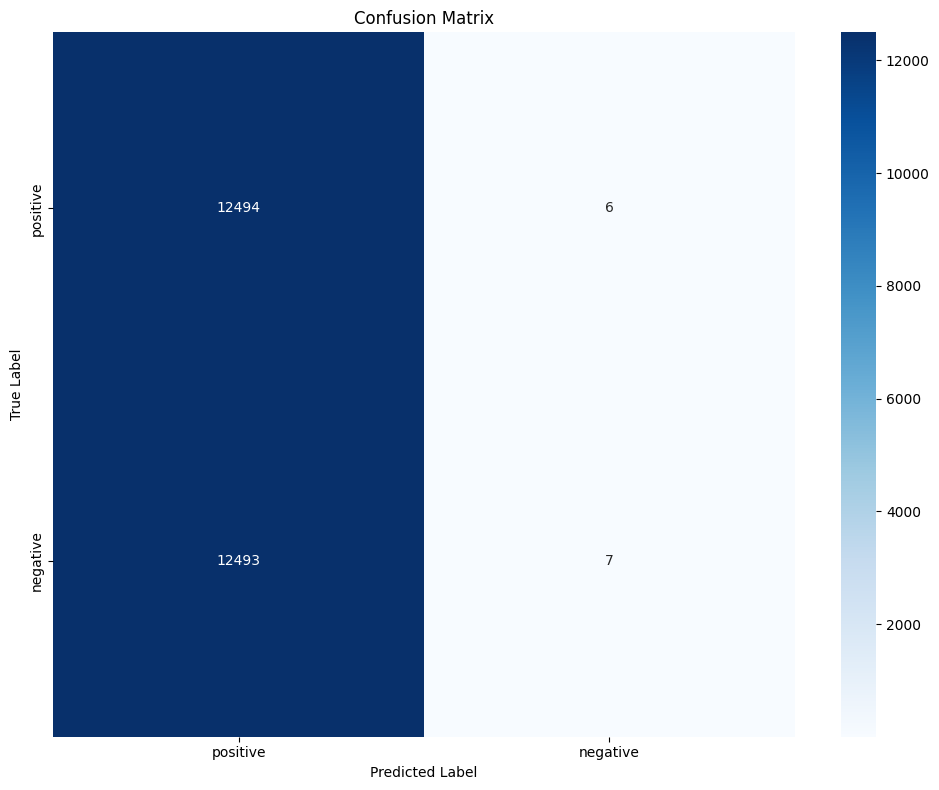

In [40]:
evaluate_predictions(predictions_df=baseline_model_review_classifications, label2id=label_to_id)

Classification Report:
              precision    recall  f1-score   support

    positive     0.8529    0.8508    0.8519     12500
    negative     0.8512    0.8533    0.8522     12500

    accuracy                         0.8520     25000
   macro avg     0.8520    0.8520    0.8520     25000
weighted avg     0.8520    0.8520    0.8520     25000



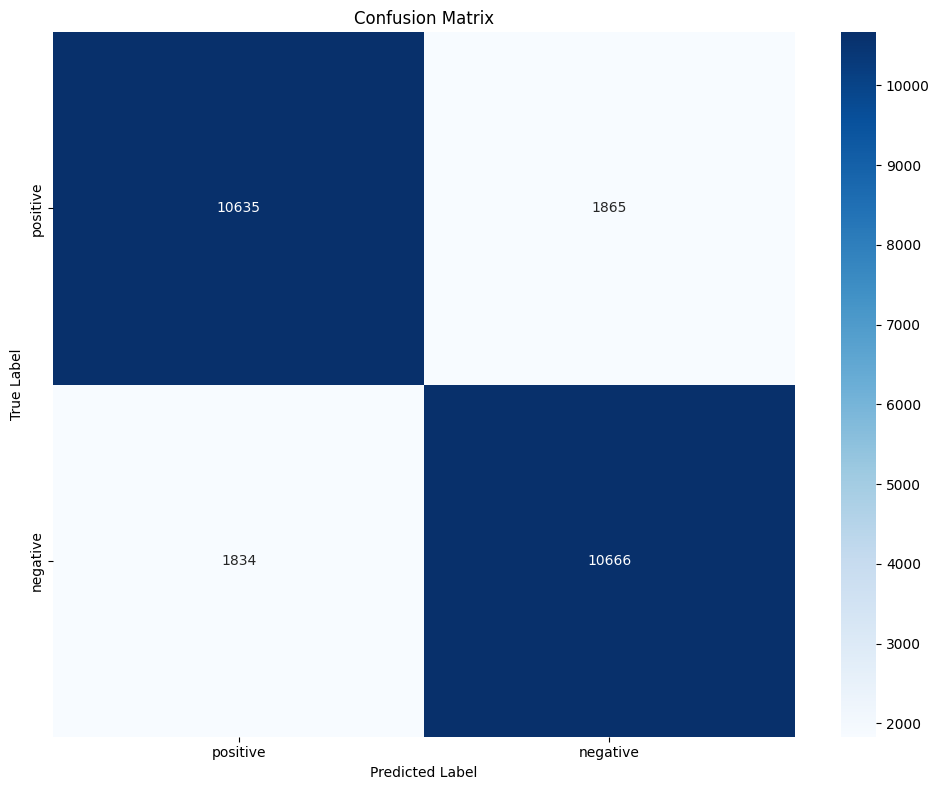

In [41]:
evaluate_predictions(predictions_df=finetuned_model_review_classifications, label2id=label_to_id)